<a href="https://colab.research.google.com/github/eviatarbach/variational_filtering/blob/main/Kuramoto_Shivashinksy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
n_ensemble = 10

#ensemble_init = np.random.randn(N, n_ensemble) * 0.01
ensemble_init = np.random.multivariate_normal(initial_state, Q, n_ensemble).T
radius = 2
local_mat = np.ones(N)
# Run the Kalman Filter for Lorenz 96
data_storage = stochastic_ensemble_kalman_filter(kuramoto_shivashinsky, N, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, local_mat)
average_state = np.mean(data_storage['states'], axis=2)  # Calculate the mean along the ensemble dimension


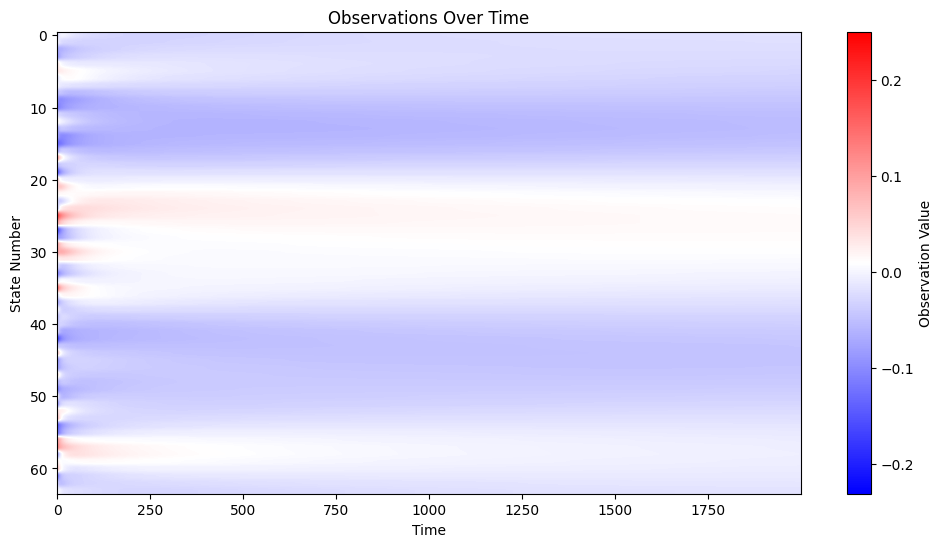

In [ ]:
n_timesteps = 2000
dt = 0.001
observation_interval = 250  # Adjust as needed
observations, states = generate_observations(kuramoto_shivashinsky, truth_init, n_timesteps, dt, observation_interval, R, Q, H)
visualize_sptemp_observations(states)


In [ ]:
import numpy as np

#adapted from https://github.com/neuraloperator/markov_neural_operator/blob/main/data_generation/KS/ks.m

#Gaussian Random Field
def GRF1(N, m, gamma, tau, sigma, type, L=1):
    if type == "dirichlet":
        m = 0

    if type == "periodic":
        my_const = 2 * np.pi / L
    else:
        my_const = np.pi

    my_eigs = np.sqrt(2) * (abs(sigma) * ((my_const * (np.arange(1, N+1)))**2 + tau**2)**(-gamma/2))

    if type == "dirichlet":
        alpha = np.zeros(N)
    else:
        xi_alpha = np.random.randn(N)
        alpha = my_eigs * xi_alpha

    if type == "neumann":
        beta = np.zeros(N)
    else:
        xi_beta = np.random.randn(N)
        beta = my_eigs * xi_beta

    a = alpha / 2
    b = -beta / 2

    c = np.concatenate([np.flipud(a) - np.flipud(b) * 1j, [m + 0j], a + b * 1j])

    if type == "periodic":
        # For simplicity, directly use numpy's FFT functions for trigonometric interpolation
        return lambda x: np.fft.ifft(np.fft.fftshift(c)).real
    else:
        # Adjust for non-periodic, though this might need further refinement for exact Chebfun behavior
        return lambda x: np.interp(x, np.linspace(-np.pi, np.pi, len(c)), np.fft.ifft(np.fft.fftshift(c)).real)


In [ ]:
from scipy.fft import fft, ifft
import numpy as np

def KS_step(u, k, E, E2, Q, f1, f2, f3, g, h):
    v = fft(u)
    Nv = g * fft(np.real(ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * fft(np.real(ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * fft(np.real(ifft(b))**2)
    c = E2 * a + Q * (2*Nb - Nv)
    Nc = g * fft(np.real(ifft(c))**2)
    v_next = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    u_next = np.real(ifft(v_next))

    return u_next

# Precompute constants needed for the time step function
def precompute_constants(s, l, h, M):
    k = (2 * np.pi / l) * np.concatenate([np.arange(0, s//2), [0], np.arange(-s//2+1, 0)])
    L = k**2 - k**4
    E = np.exp(h*L)
    E2 = np.exp(h*L/2)
    r = np.exp(1j * np.pi * (np.arange(1, M+1)-.5) / M)
    LR = h * np.tile(L, (M, 1)).T + np.tile(r, (s, 1))
    Q = h * np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = h * np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = h * np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = h * np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
    g = -0.5j * k

    return k, E, E2, Q, f1, f2, f3, g

# Initial setup
N = 1024  # Spatial discretization
u = np.cos(np.arange(1, N+1) / 16) * (1 + np.sin(np.arange(1, N+1) / 16))  # Initial condition
l = 32 * np.pi  # Domain length
h = 0.01  # Time step
M = 64  # Number of points for complex means
s = len(u)  # Length of the state array

# Precompute constants
k, E, E2, Q, f1, f2, f3, g = precompute_constants(s, l, h, M)

# Time-stepping loop
T = 150  # Total time
nmax = round(T/h)
uu = np.empty((nmax, s))  # Array to store state at each time step
uu[0, :] = u  # Set initial condition

for n in range(1, nmax):
    u = KS_step(u, k, E, E2, Q, f1, f2, f3, g, h)
    uu[n, :] = u  # Store the state

# Now, uu contains the state at each time step


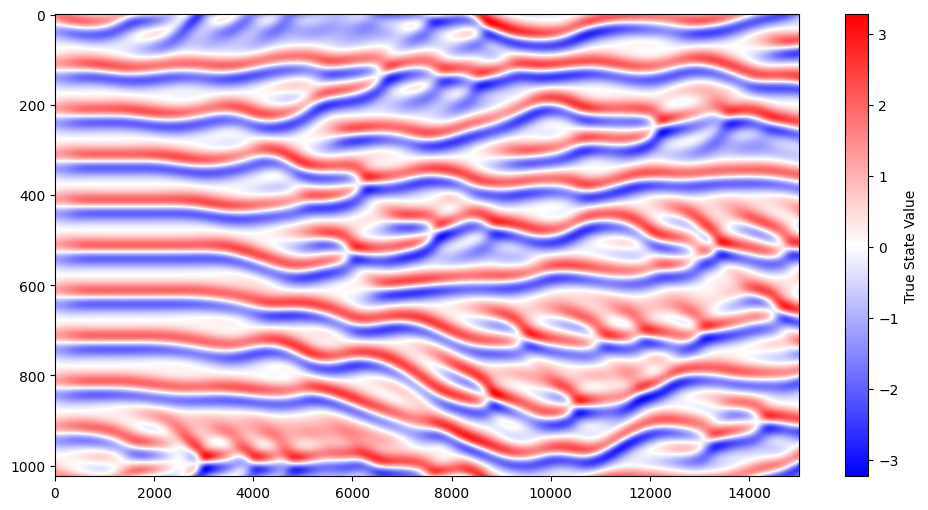

In [ ]:
cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])
# Create a separate grid plot for true states
plt.figure(figsize=(12, 6))
plt.imshow(uu.T, cmap=cmap, aspect='auto')
plt.colorbar(label='True State Value')


In [201]:
def generate_observations(model, initial_state, n_timesteps, dt, observation_interval, R, Q, H):
    state = initial_state
    observations = {}
    true_states = {}
    for t in range(n_timesteps):
        true_states[t] = state
        state = model(state, dt)
        # if t % observation_interval == 0:
        #     noisy_state = state + np.random.multivariate_normal(np.zeros(state.shape[0]), Q)
        #     observations[t] = H @ noisy_state + np.random.multivariate_normal(np.zeros(H.shape[0]), R)
    return observations, true_states

H = np.eye(N)  # Assuming full observation for simplicity
Qcov = 0.02 * np.eye(N)  # Model noise covariance
R = 0.2 * np.eye(N) # Observation noise covariance
# Precompute constants for KS_step
k, E, E2, Q_ks, f1, f2, f3, g = precompute_constants(N, l, h, M)

# Define the KS model as a lambda function to match the expected function signature.
KS_model = lambda state, dt: KS_step(state, k, E, E2, Q_ks, f1, f2, f3, g, dt)

h = 0.01
time = 500
n_timesteps = int(time/h)
# Set up the initial state
initial_state = np.cos(np.arange(1, N+1) / 16) * (1 + np.sin(np.arange(1, N+1) / 16))

# Assume R, Q, and H are defined as covariance matrices and the observation matrix respectively.
# Now call generate_observations using the KS_model.
observations, true_states = generate_observations(KS_model, initial_state, n_timesteps, h, observation_interval, R, Qcov, H)


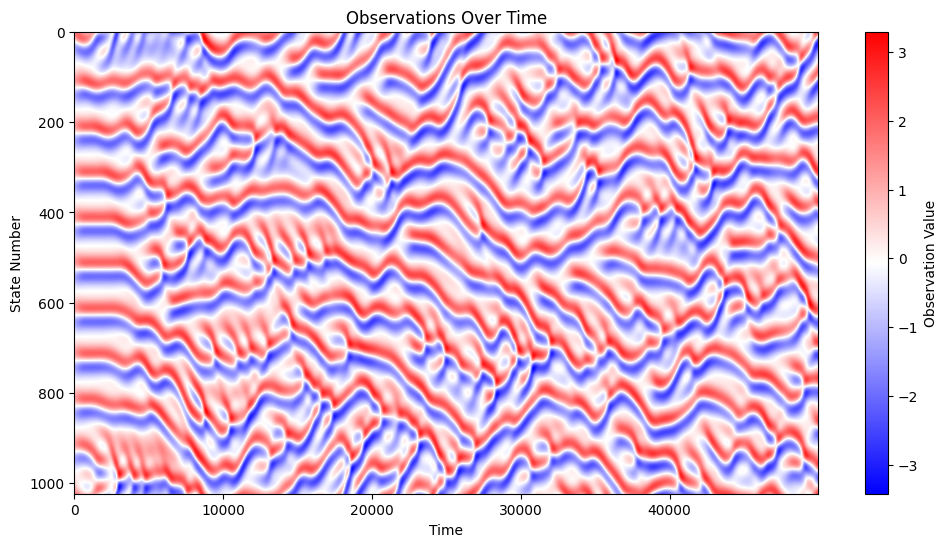

In [203]:
def visualize_observations(observations):
    # Extract timestamps and observation values
    timestamps = list(observations.keys())
    obs = list(observations.values())
    observation_values = np.array(obs).T
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])
    # Create a grid plot
    plt.figure(figsize=(12, 6))
    plt.imshow(observation_values, cmap=cmap, aspect='auto')#, vmin=-6, vmax=6)
    plt.colorbar(label='Observation Value')
    plt.xlabel('Time')
    plt.ylabel('State Number')
    plt.title('Observations Over Time')
    plt.show()
visualize_observations(true_states)